In [193]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import scipy.signal
import torch
import torch.nn as nn
import torchsummary
import heapq
from sklearn.svm import SVR
import deepdish as dd
from sklearn import preprocessing 

In [194]:
#inisialize
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("cpu")

print(f'Devices: {device}')

Devices: cpu


In [195]:
#read file and load models path
h5path = '/Users/mclinwong/GitHub/CodesReproduction/DCN-DOA/Data/h5/'
pthpath = '/Users/mclinwong/GitHub/CodesReproduction/DCN-DOA/Data/pth/'
#read mat file
matpath = '/Users/mclinwong/GitHub/CodesReproduction/DCN-DOA/Data/matlib/'
figurepath = '/Users/mclinwong/GitHub/CodesReproduction/DCN-DOA/ReproducedCodes/Figures'
read_temp=scipy.io.loadmat(matpath + 'data2_test.mat')
S_est=read_temp['S_est']
S_est = S_est.transpose(0, 2, 1)
S_real = np.real(S_est)
S_imag = np.imag(S_est)
S_abs = np.append(S_real, S_imag, axis=2)
S_label=read_temp['S_label']
R_est=read_temp['R_est']
DOA_train=read_temp['DOA_train']
theta=read_temp['theta']
gamma=read_temp['gamma']
gamma_R=read_temp['gamma_R']
S_label1 = np.expand_dims(S_label, 2)
normalizer = preprocessing.Normalizer().fit(R_est)
[r2,I,c] = np.shape(S_est)
[r2,c]=np.shape(R_est)
[r2,I]=np.shape(S_label)
print(f'r2: {r2}, I: {I}, c: {c}')


r2: 5, I: 120, c: 56


In [196]:
class CNN_ReLu(nn.Module):
    def __init__(self):
        super(CNN_ReLu, self).__init__()
        self.cnn_1 = nn.Conv1d(in_channels=2, out_channels=12, kernel_size=25, padding=12)
        self.cnn_2 = nn.Conv1d(in_channels=12, out_channels=6, kernel_size=15, padding=7)
        self.cnn_3 = nn.Conv1d(in_channels=6, out_channels=3, kernel_size=5, padding=2)
        self.cnn_4 = nn.Conv1d(in_channels=3, out_channels=1, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.relu(self.cnn_1(x))
        x = self.relu(self.cnn_2(x))
        x = self.relu(self.cnn_3(x))
        x = self.relu(self.cnn_4(x))
        return x
cnnrelu = torch.load(pthpath + 'cnnrelu.pth')

In [197]:
class CNN_tanh(nn.Module):
    def __init__(self):
        super(CNN_tanh, self).__init__()
        self.cnn_1 = nn.Conv1d(in_channels=2, out_channels=12, kernel_size=25, padding=12)
        self.cnn_2 = nn.Conv1d(in_channels=12, out_channels=6, kernel_size=15, padding=7)
        self.cnn_3 = nn.Conv1d(in_channels=6, out_channels=3, kernel_size=5, padding=2)
        self.cnn_4 = nn.Conv1d(in_channels=3, out_channels=1, kernel_size=3, padding=1)
        self.tanh = nn.Tanh()
    def forward(self, x):
        x = self.tanh(self.cnn_1(x))
        x = self.tanh(self.cnn_2(x))
        x = self.tanh(self.cnn_3(x))
        x = self.tanh(self.cnn_4(x))
        return x
cnntanh = torch.load(pthpath + 'cnntanh.pth')

In [198]:
class DNN_ReLU(nn.Module):
    def __init__(self):
        super(DNN_ReLU, self).__init__()
        self.fc1 = nn.Linear(2*L, int(2*L/3))
        self.fc2 = nn.Linear(int(2*L/3), int(4*L/9))
        self.fc3 = nn.Linear(int(4*L/9), int(2*L/3))
        self.fc4 = nn.Linear(int(2*L/3), L)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        return x
dnnrelu = torch.load(pthpath + 'dnnrelu.pth') 

In [199]:
class DNN_Tanh(nn.Module):
    def __init__(self):
        super(DNN_Tanh, self).__init__()
        self.fc1 = nn.Linear(2*L, int(2*L/3))
        self.fc2 = nn.Linear(int(2*L/3), int(4*L/9))
        self.fc3 = nn.Linear(int(4*L/9), int(2*L/3))
        self.fc4 = nn.Linear(int(2*L/3), L)
        self.tanh = nn.Tanh()
    def forward(self, x):
        x = self.tanh(self.fc1(x))
        x = self.tanh(self.fc2(x))
        x = self.tanh(self.fc3(x))
        x = self.tanh(self.fc4(x))
        return x
dnntanh = torch.load(pthpath + 'dnntanh.pth')

In [200]:
def Test(model, inputx):
    model = model.to(device)
    model.eval()
    ls = []
    for i in range(r2):
        with torch.no_grad():
            x = torch.from_numpy(inputx[i,:,:]).float().to(device)
            x = x.to(device)
            y = model(x)
            y = y.cpu().numpy()
            ls.append(y)
    predict = np.array(ls)
    return predict

In [201]:
#Testing
predict_dnnrelu = Test(dnnrelu, S_abs)
predict_dnntanh = Test(dnntanh, S_abs)
predict_cnnrelu = Test(cnnrelu, S_est)
predict_cnntanh = Test(cnntanh, S_est)
    


In [202]:
# print(R_est)
print(np.shape(predict_cnnrelu))

(5, 1, 120)


In [203]:
# DOA_plot = [50 ,160 ,320]

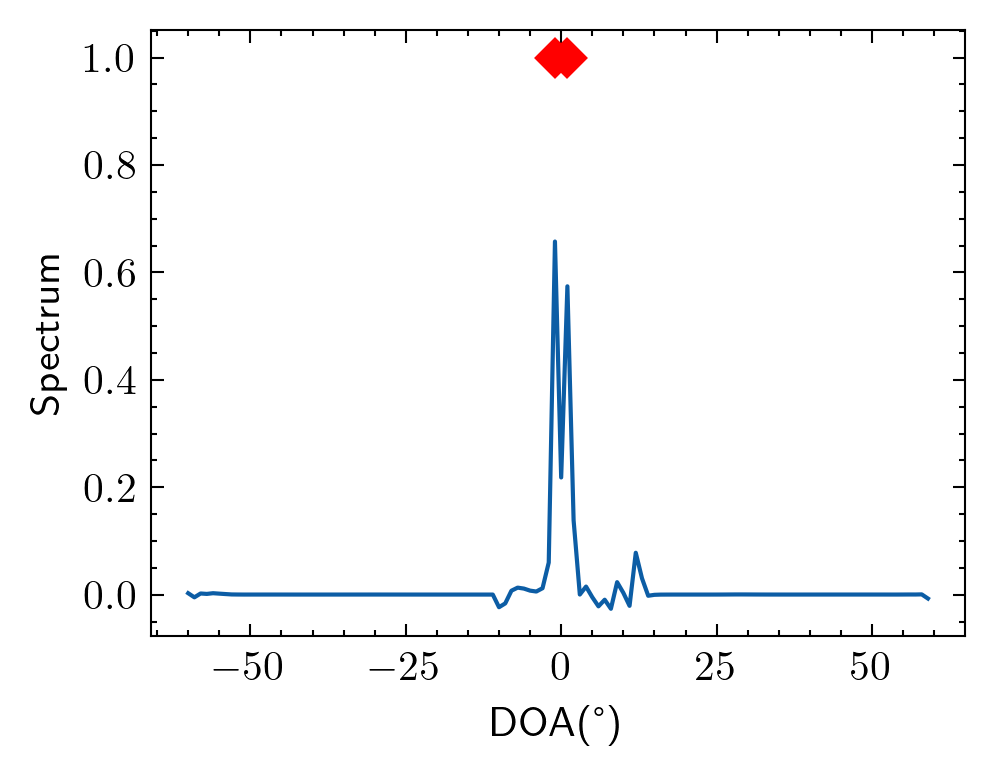

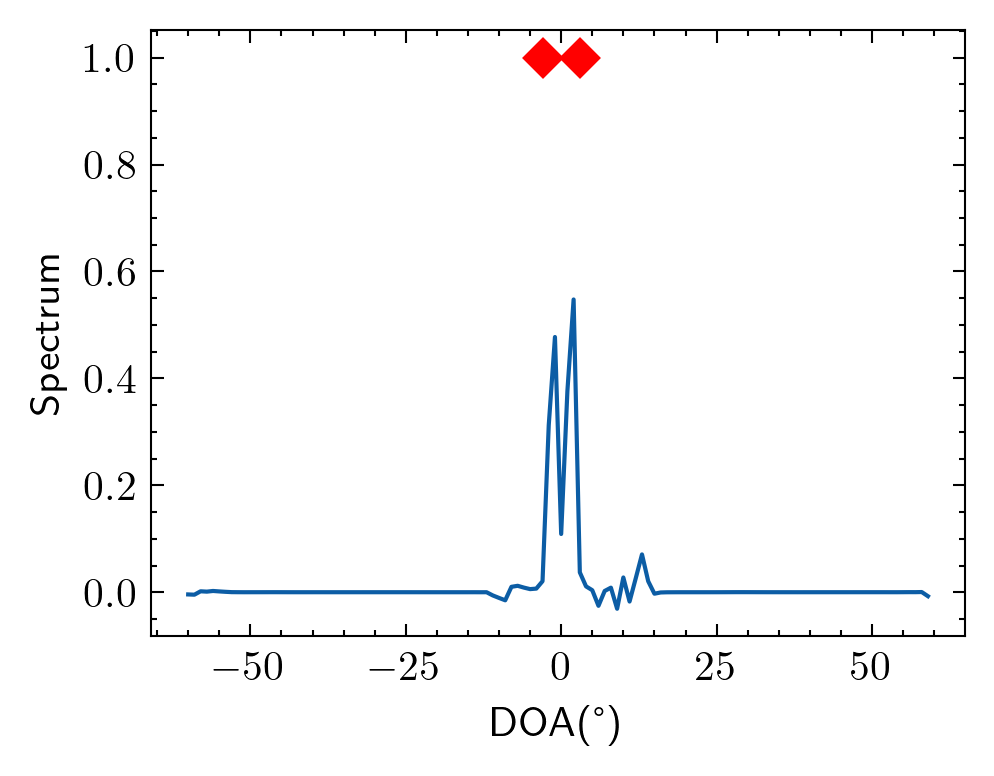

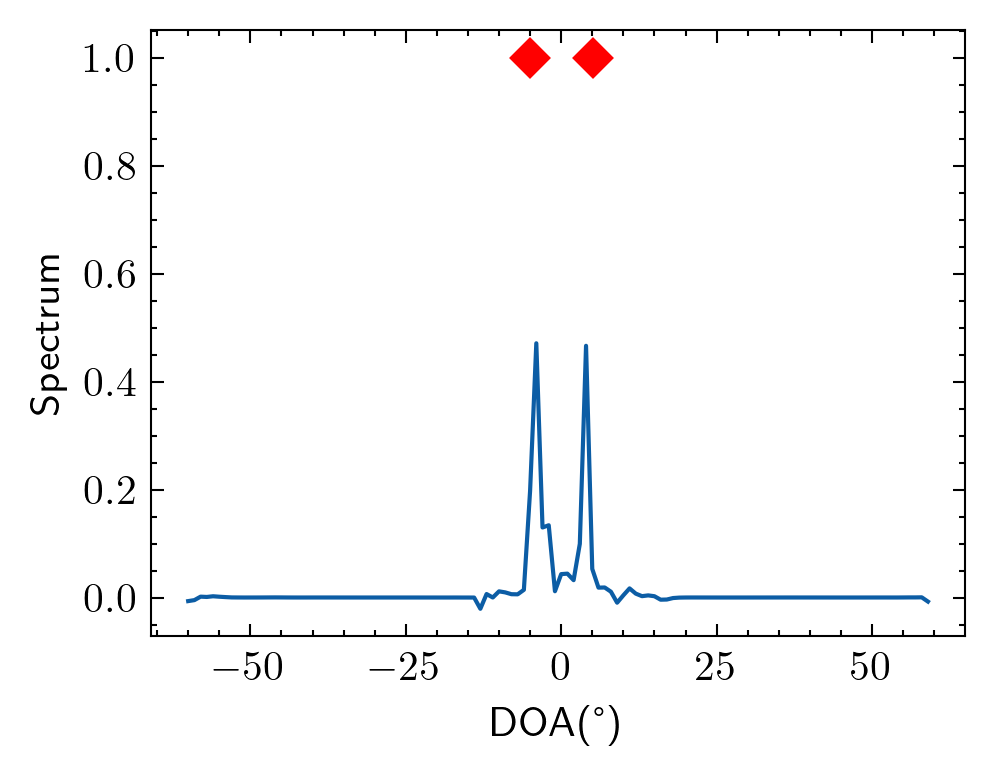

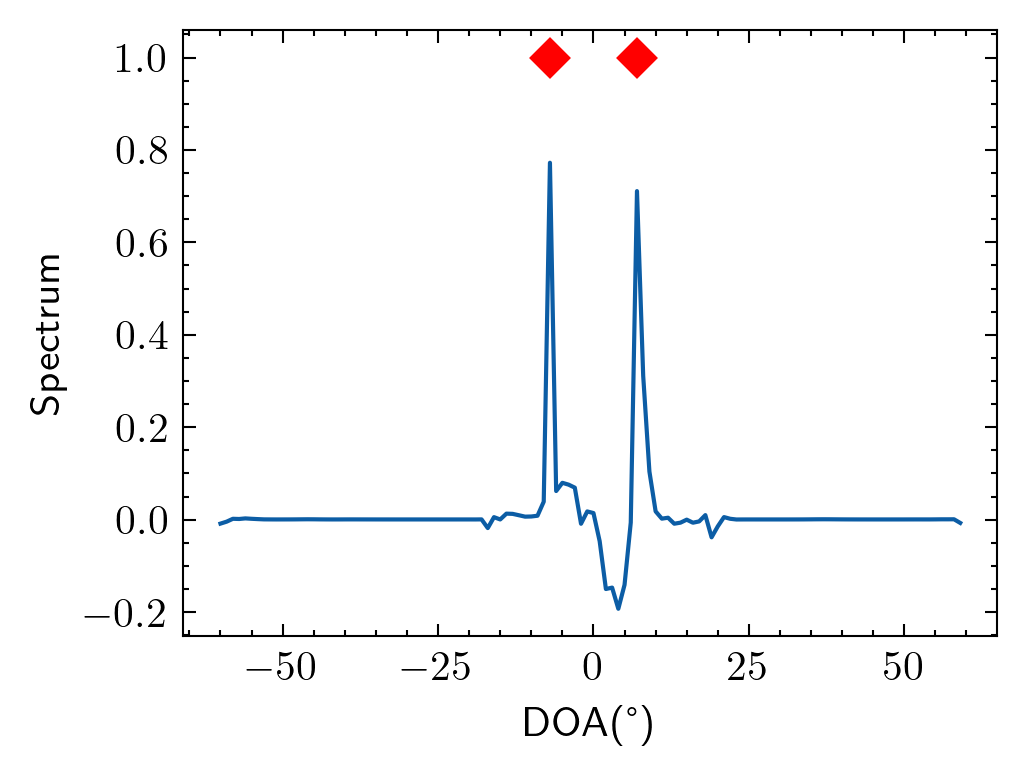

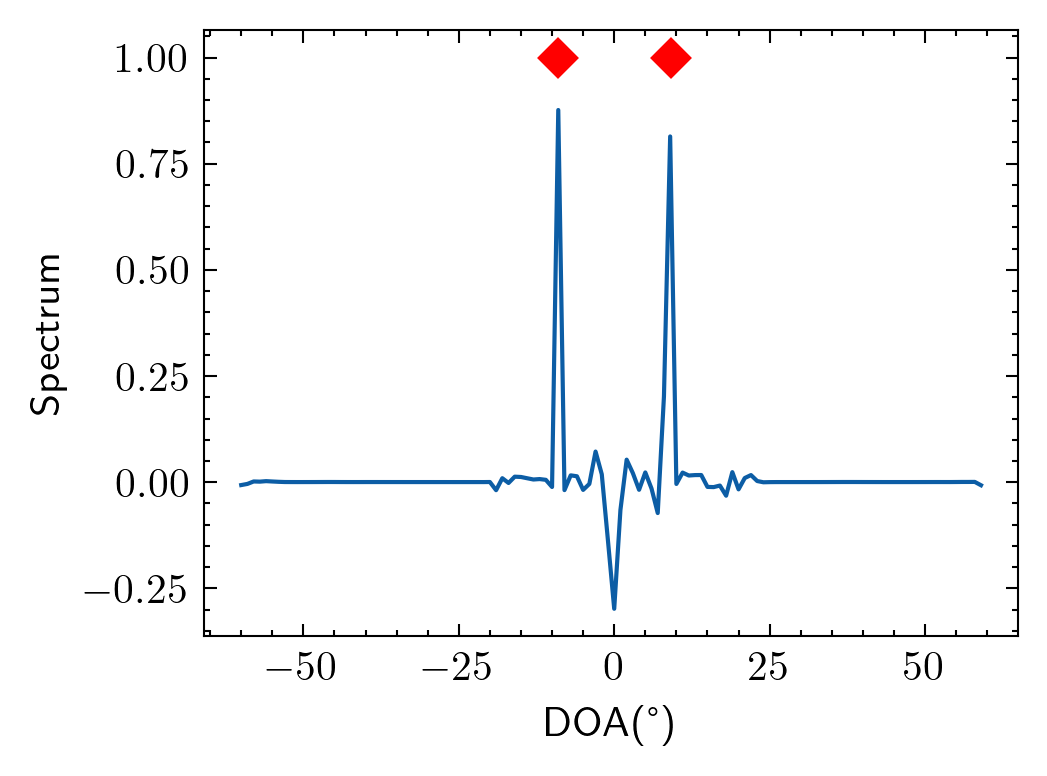

In [220]:
with plt.style.context(['science']):
    DOA_plot = np.arange(r2)
    for i in DOA_plot:
        plt.rcParams['figure.dpi'] = 300
        plt.size = (20,20)
        x = np.arange(-60,60)
        y = predict_cnntanh[i,0,:]
        plt.figure()
        plt.xlabel('DOA(°)')
        plt.ylabel('Spectrum')
        plt.plot(x, y)
        plt.plot(DOA_train[:,i],np.ones((2,)),'rD')
        plt.savefig(figurepath + '/Spectrum/DCN_Tanh/DOA'+str(i)+'.pdf')

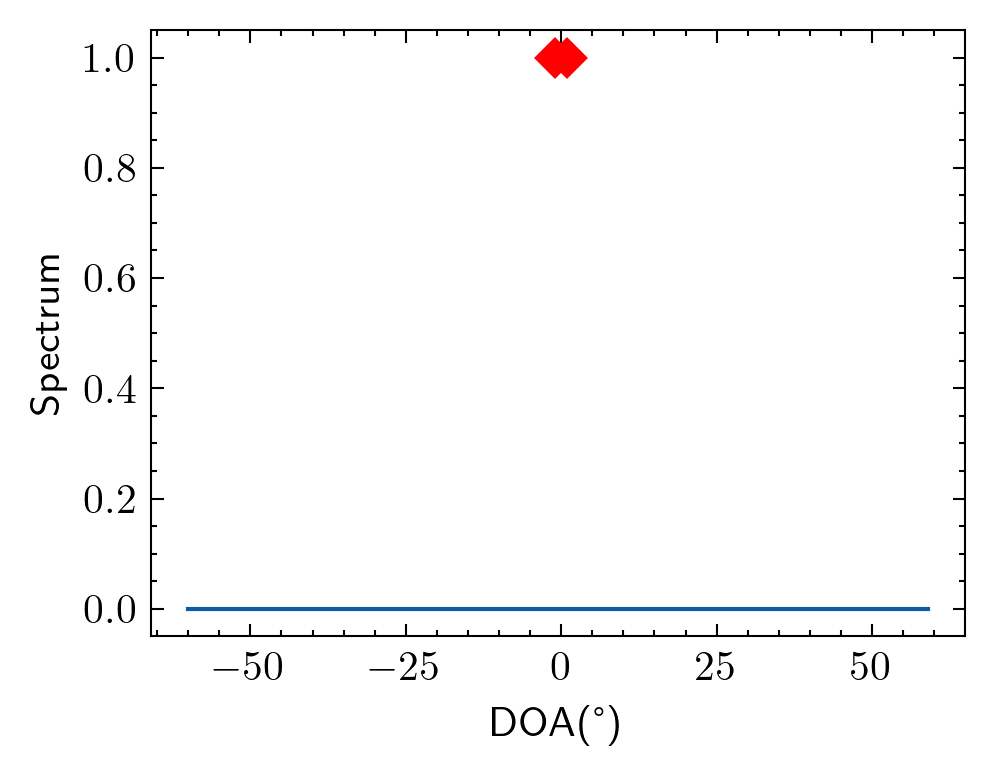

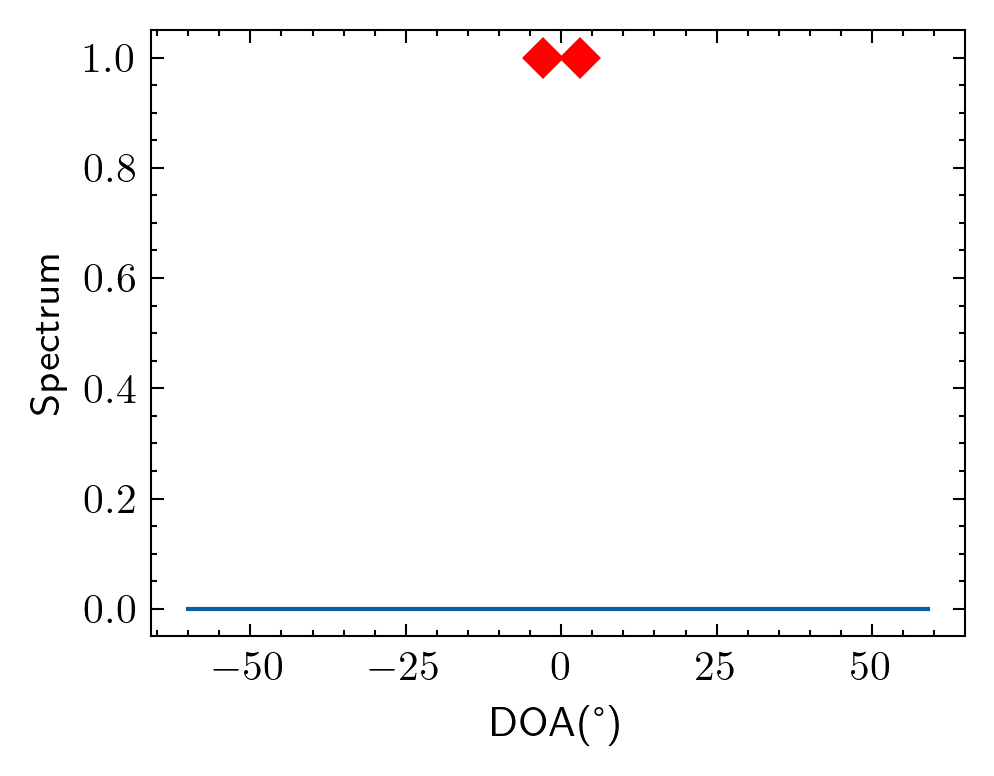

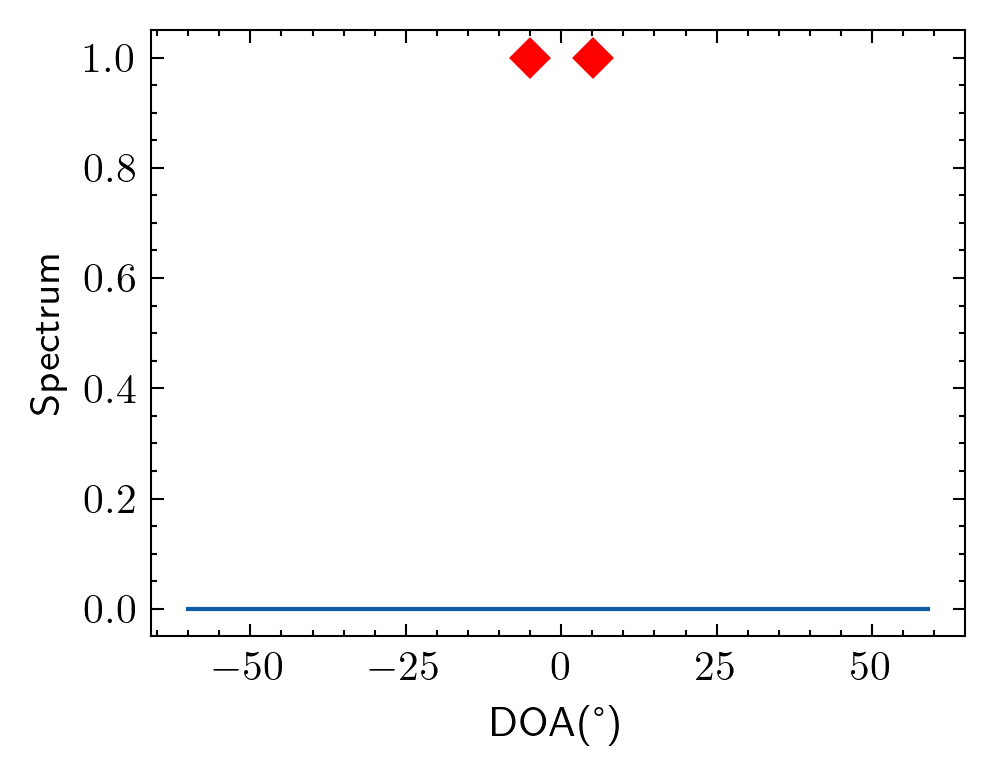

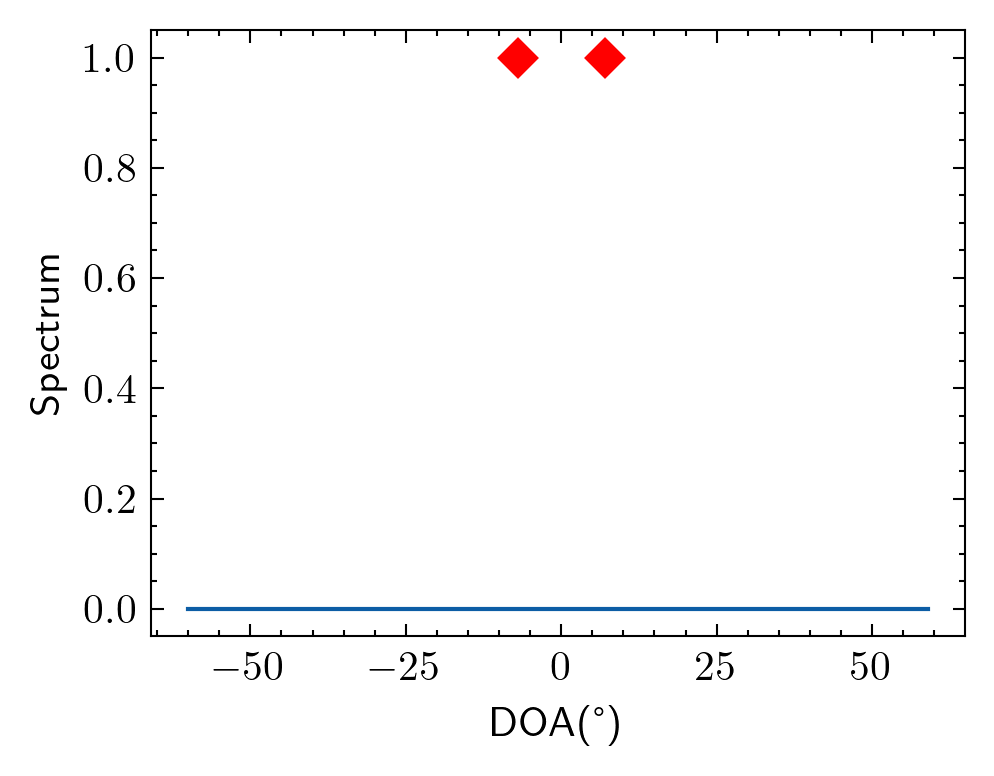

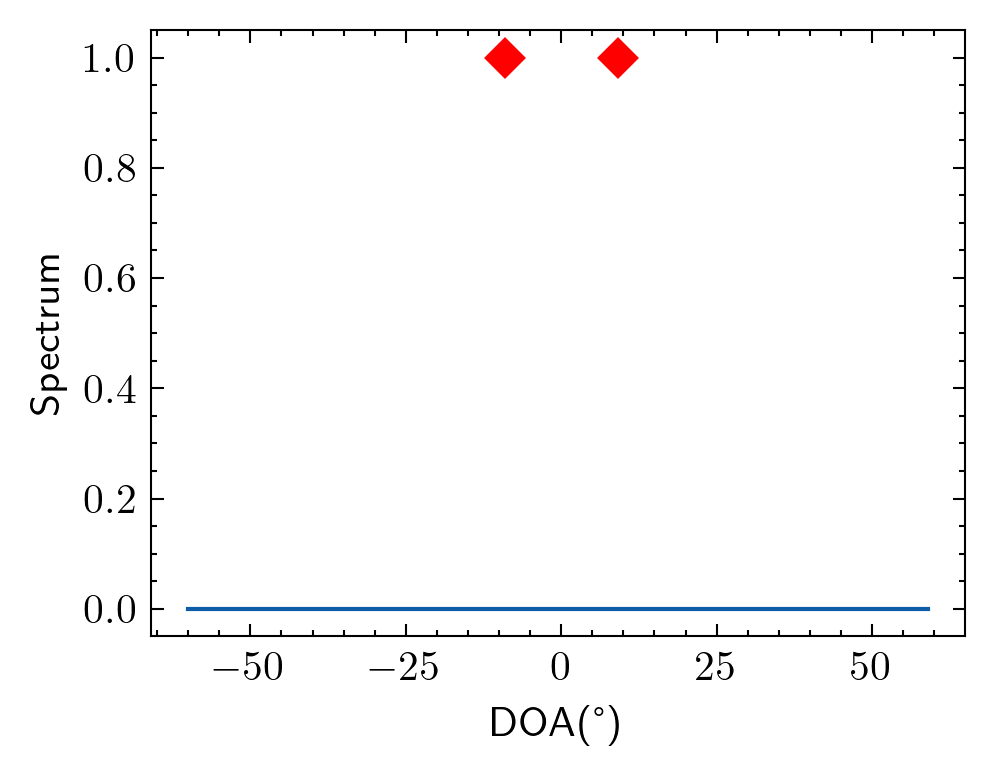

In [219]:
with plt.style.context(['science']):
    DOA_plot = np.arange(r2)
    for i in DOA_plot:
        plt.rcParams['figure.dpi'] = 300
        plt.size = (20,20)
        x = np.arange(-60,60)
        y = predict_cnnrelu[i,0,:]
        plt.figure()
        plt.xlabel('DOA(°)')
        plt.ylabel('Spectrum')
        plt.plot(x, y)
        plt.plot(DOA_train[:,i],np.ones((2,)),'rD')
        plt.savefig(figurepath + '/Spectrum/DCN_ReLU/DOA'+str(i)+'.pdf')

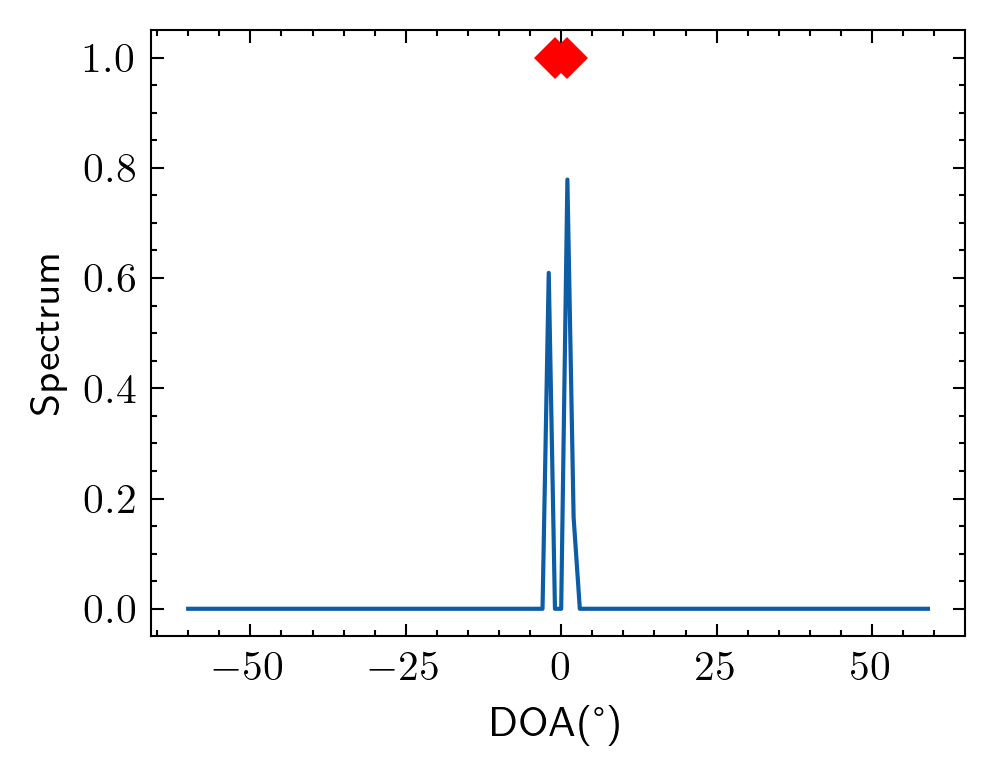

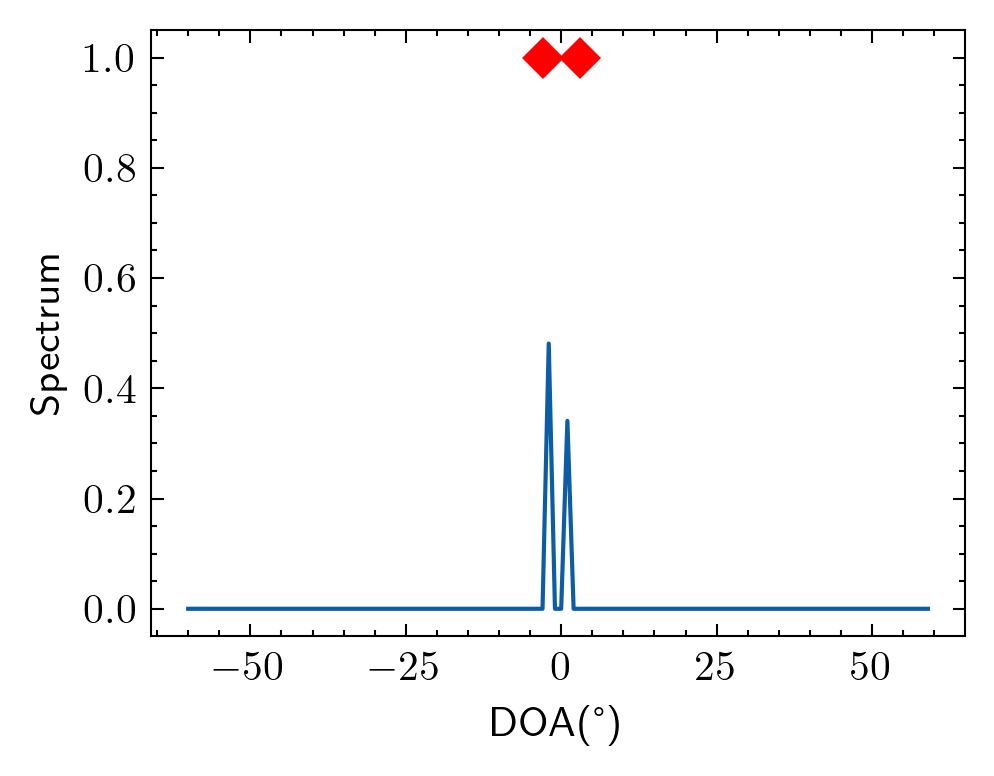

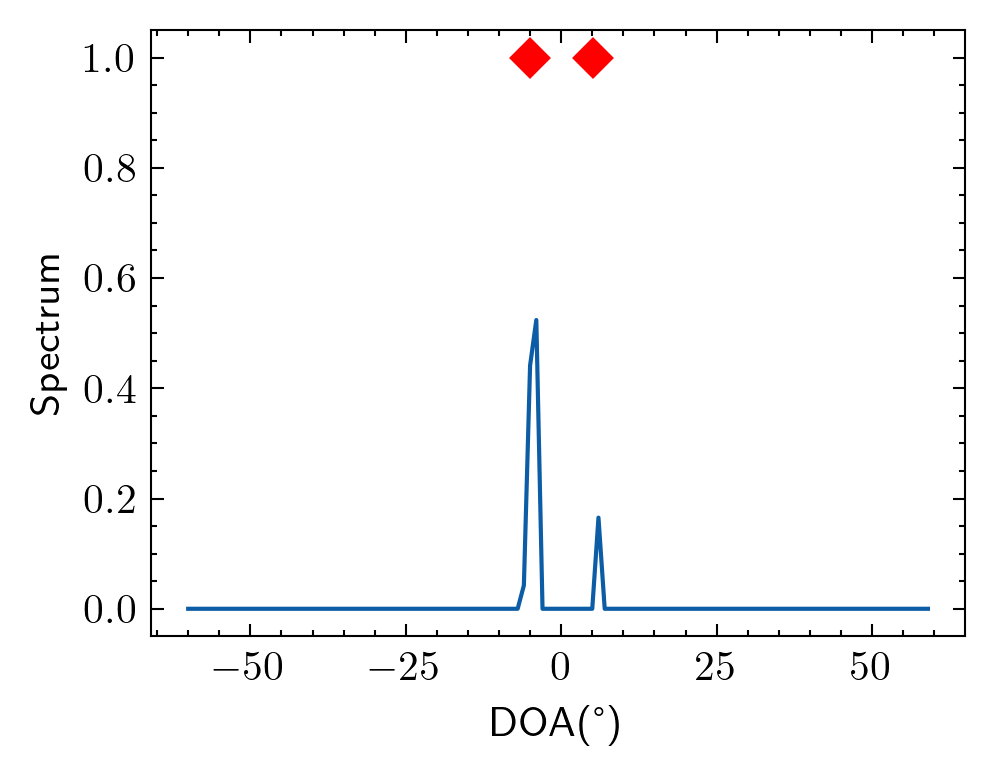

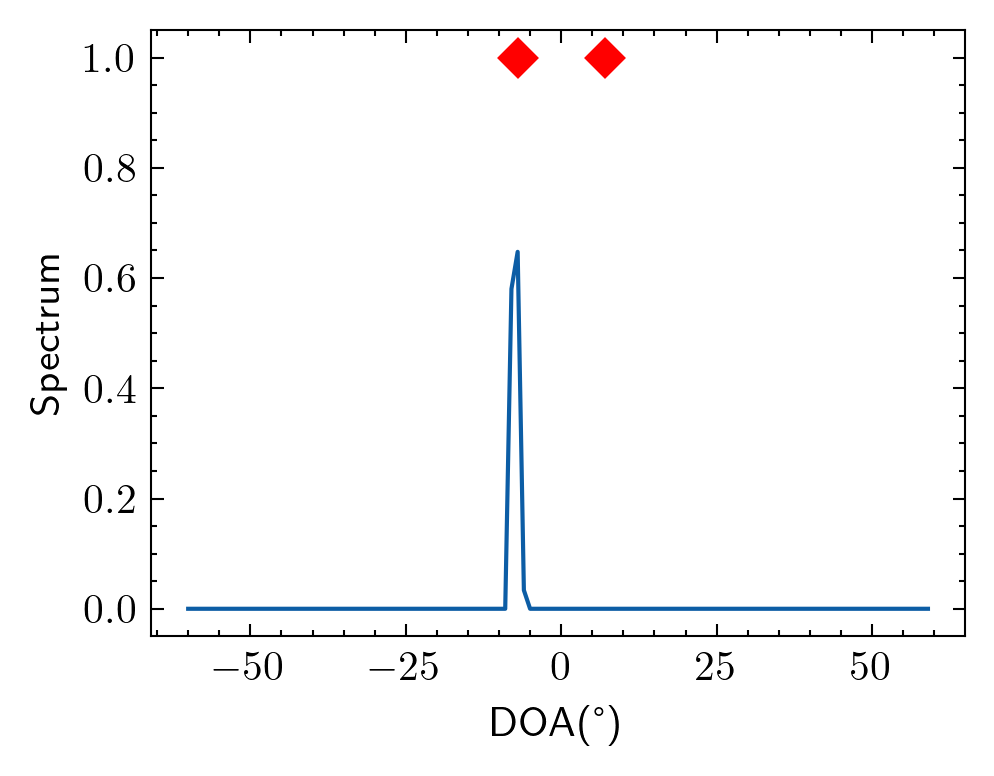

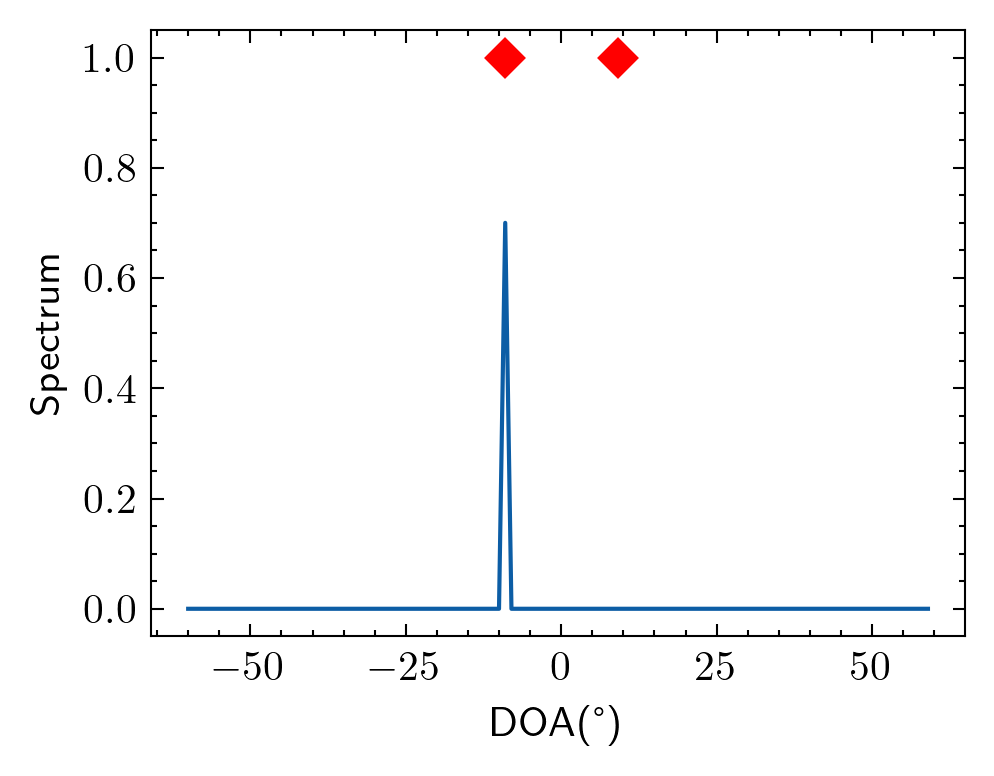

In [218]:
with plt.style.context(['science']):
    DOA_plot = np.arange(r2)
    for i in DOA_plot:
        plt.rcParams['figure.dpi'] = 300
        plt.size = (20,20)
        x = np.arange(-60,60)
        y = predict_dnnrelu[i,0,:]
        plt.figure()
        plt.xlabel('DOA(°)')
        plt.ylabel('Spectrum')
        plt.plot(x, y)
        plt.plot(DOA_train[:,i],np.ones((2,)),'rD')
        plt.savefig(figurepath + '/Spectrum/DNN_ReLU/DOA'+str(i)+'.pdf')

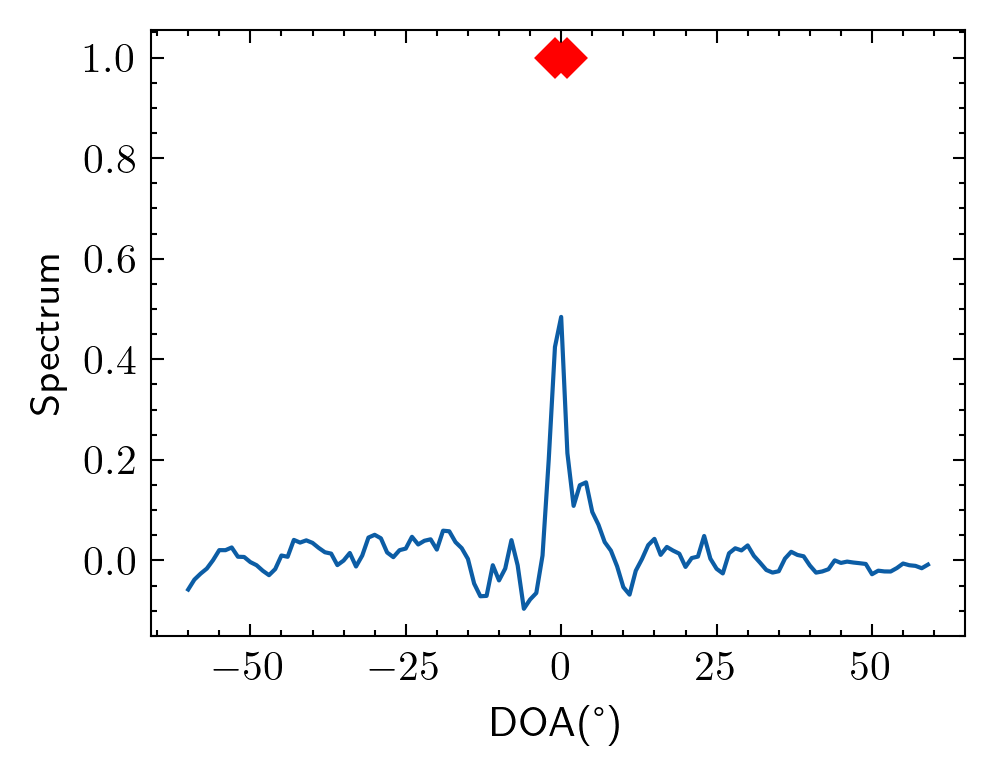

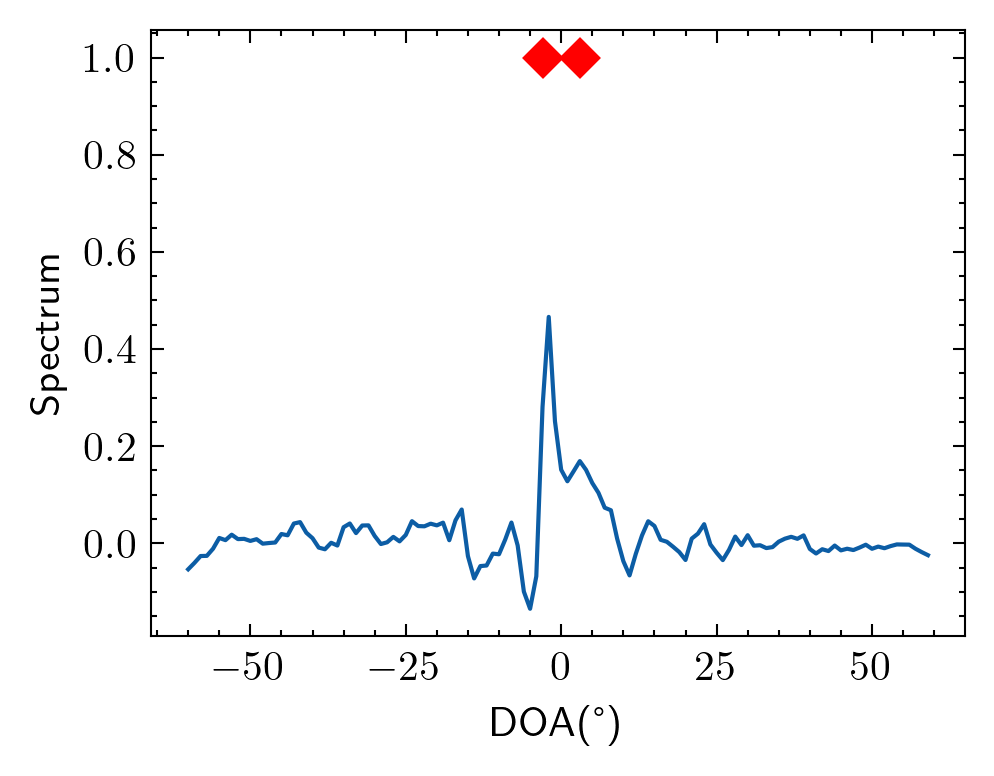

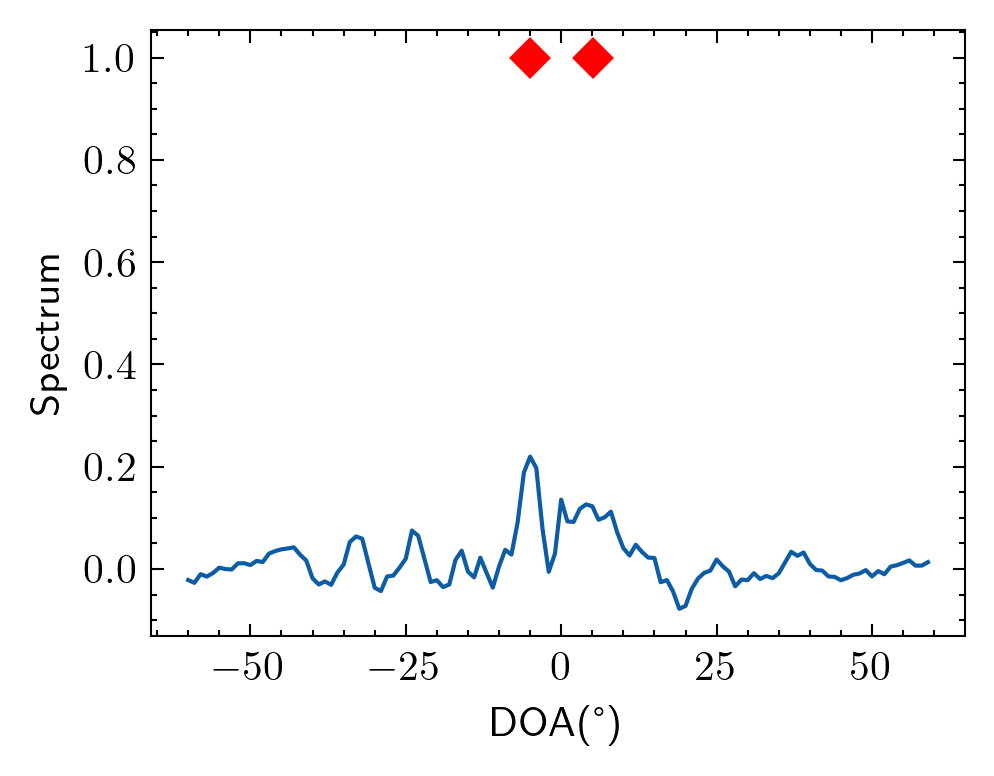

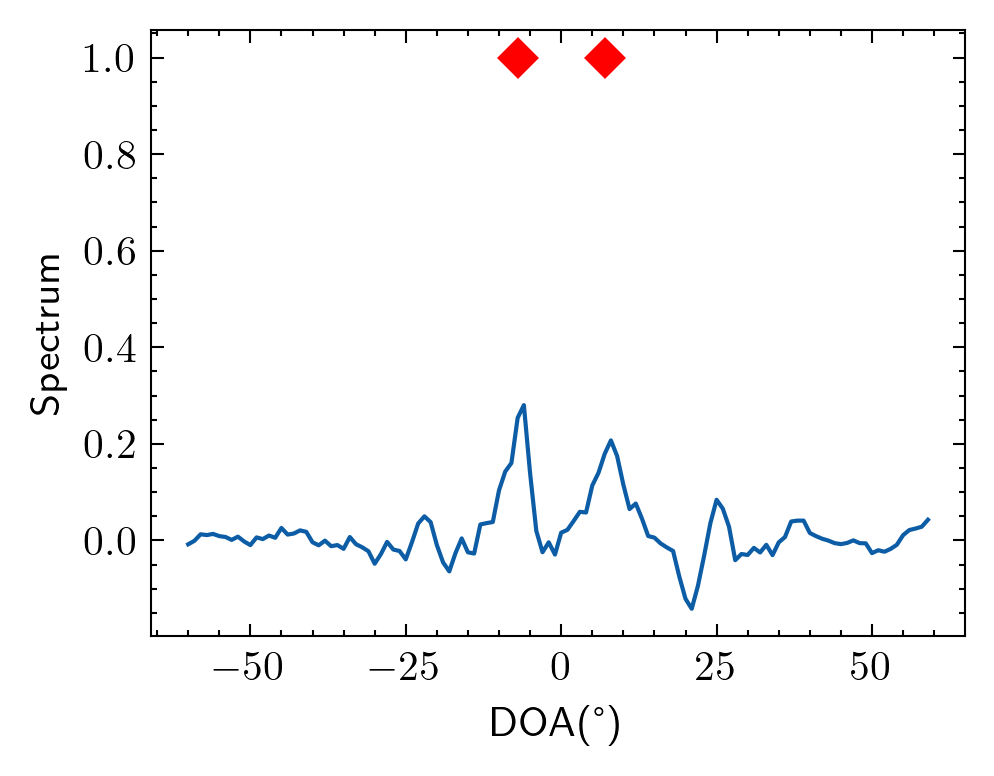

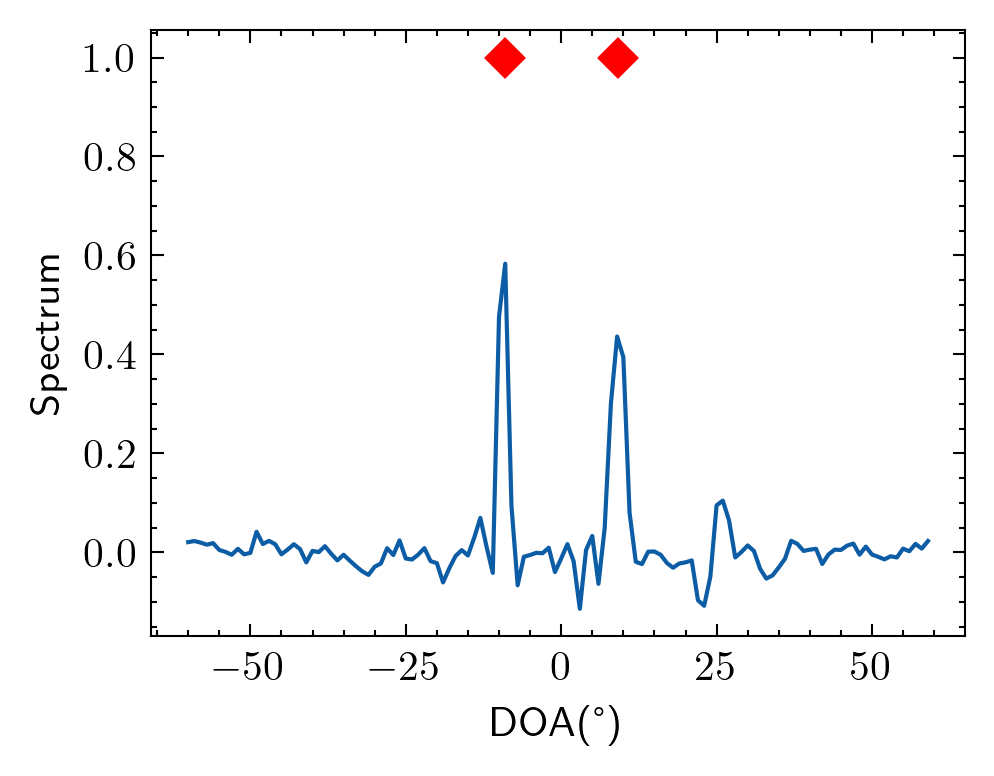

In [217]:
with plt.style.context(['science']):
    DOA_plot = np.arange(r2)
    for i in DOA_plot:
        plt.rcParams['figure.dpi'] = 300
        plt.size = (20,20)
        x = np.arange(-60,60)
        y = predict_dnntanh[i,0,:]
        plt.figure()
        plt.xlabel('DOA(°)')
        plt.ylabel('Spectrum')
        plt.plot(x, y)
        plt.plot(DOA_train[:,i],np.ones((2,)),'rD')
        plt.savefig(figurepath + '/Spectrum/DNN_Tanh/DOA'+str(i)+'.pdf')

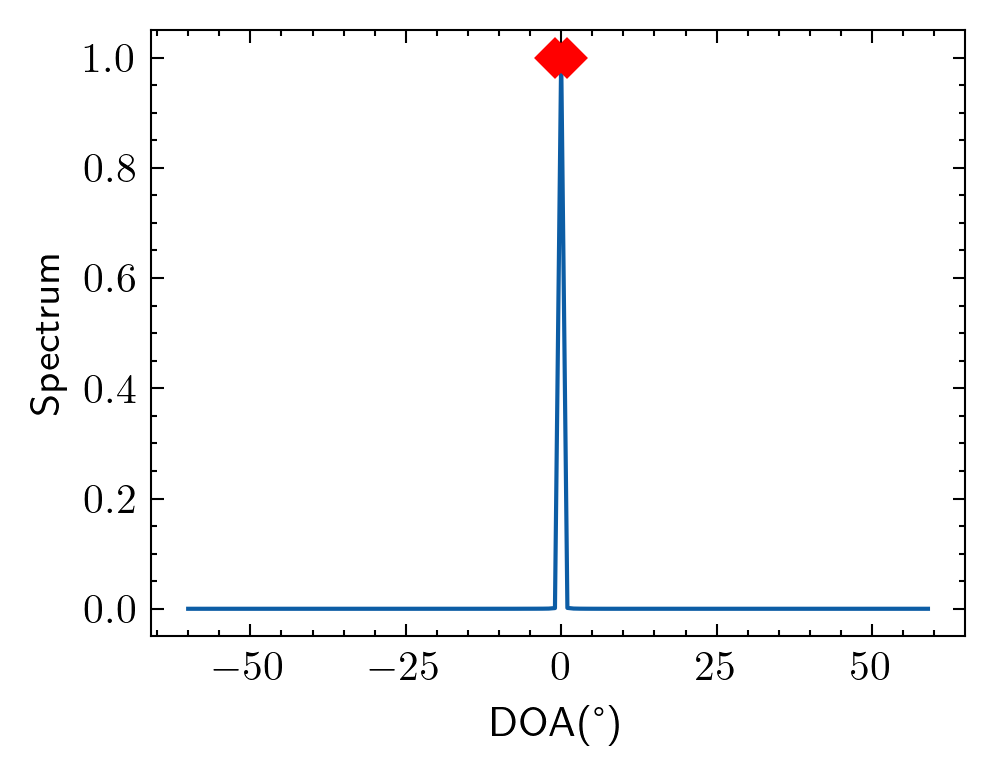

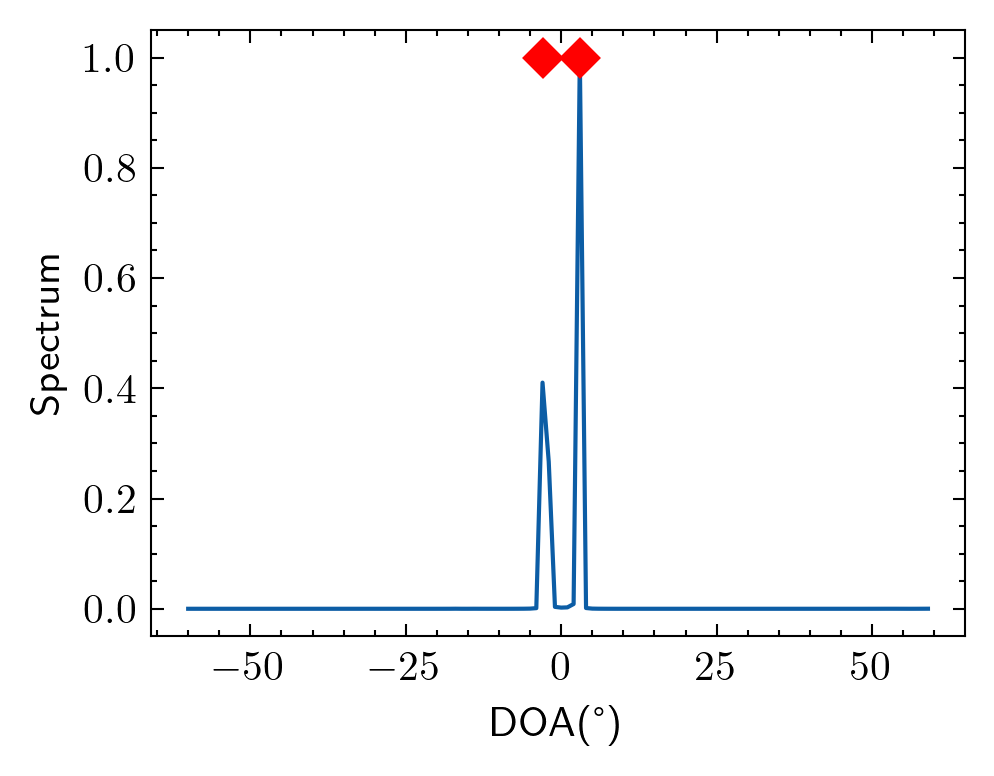

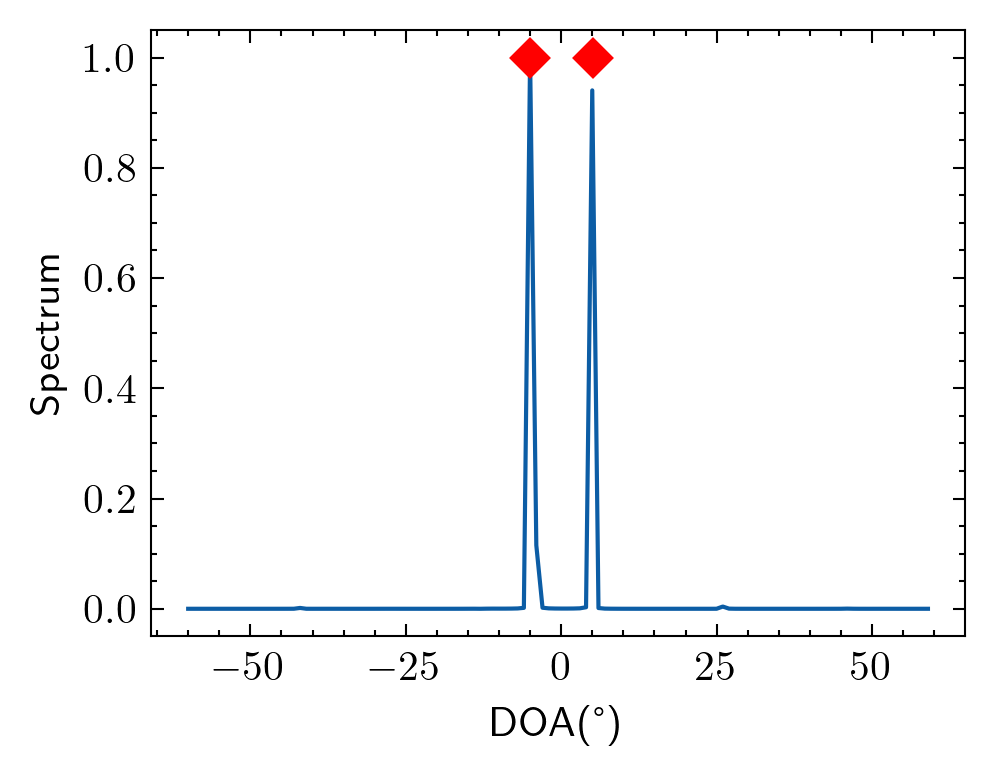

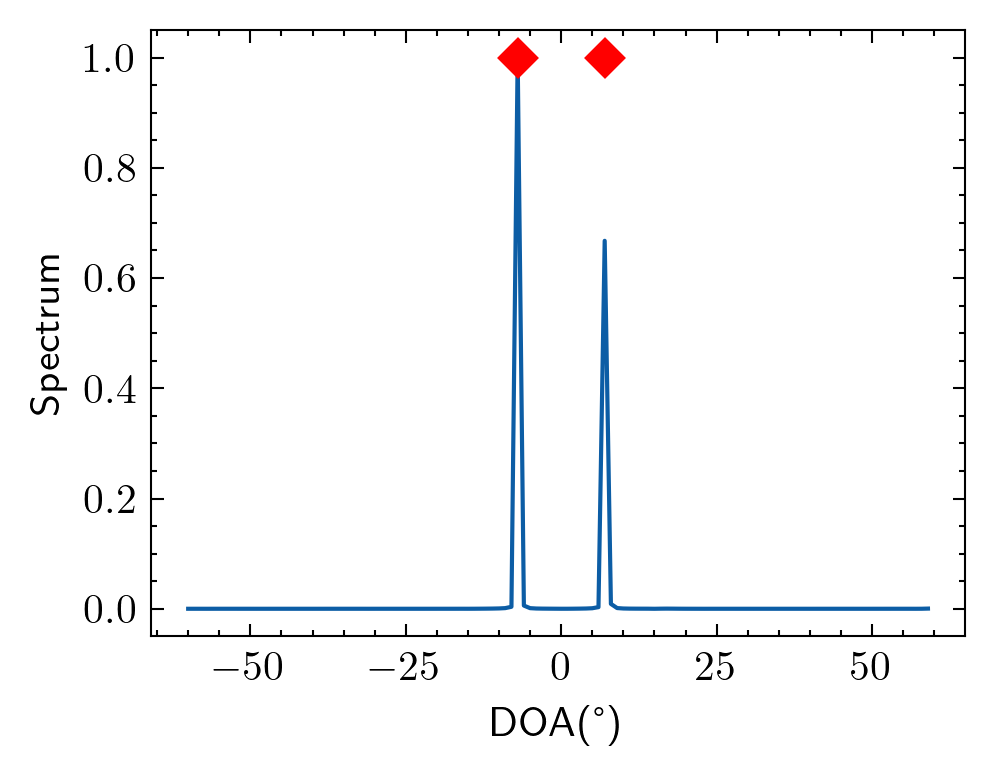

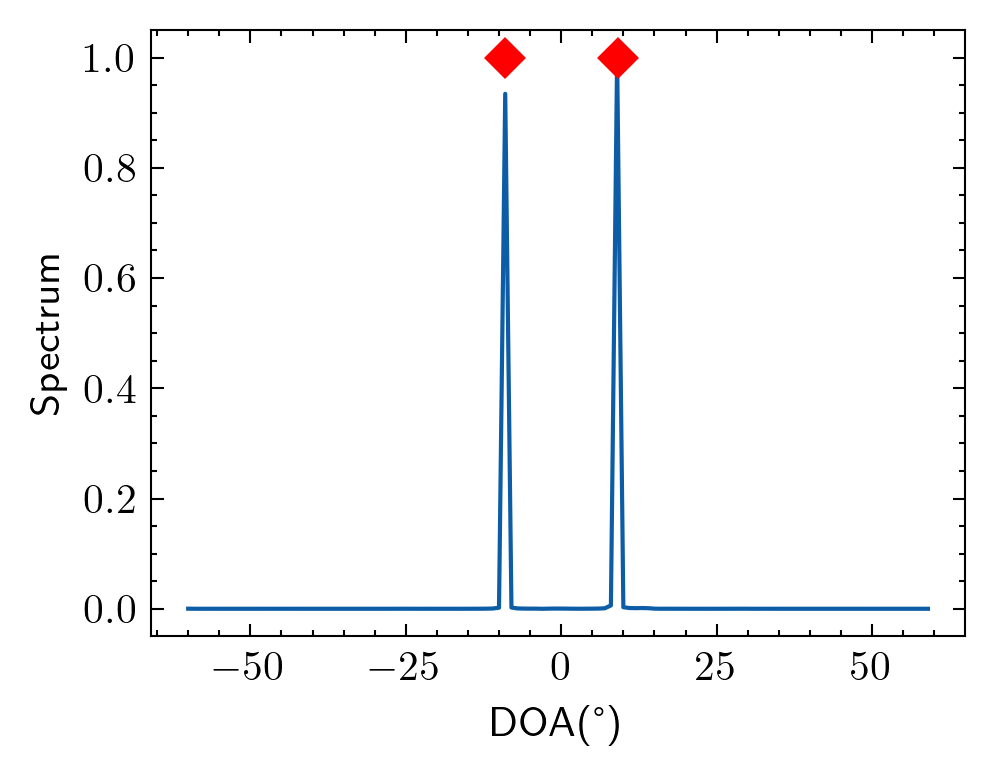

In [216]:
with plt.style.context(['science']):
    plt.rcParams['figure.dpi'] = 300
    DOA_plot = np.arange(r2)
    for i in DOA_plot:
        plt.size = (20,20)
        x = np.arange(-60,60)
        y = gamma_R[i,:]/max(gamma_R[i,:])
        plt.figure()
        plt.xlabel('DOA(°)')
        plt.ylabel('Spectrum')
        plt.plot(x, y)
        plt.plot(DOA_train[:,i],np.ones((2,)),'rD')
        plt.savefig(figurepath + '/Spectrum/SBLR/DOA'+str(i)+'.pdf')
    

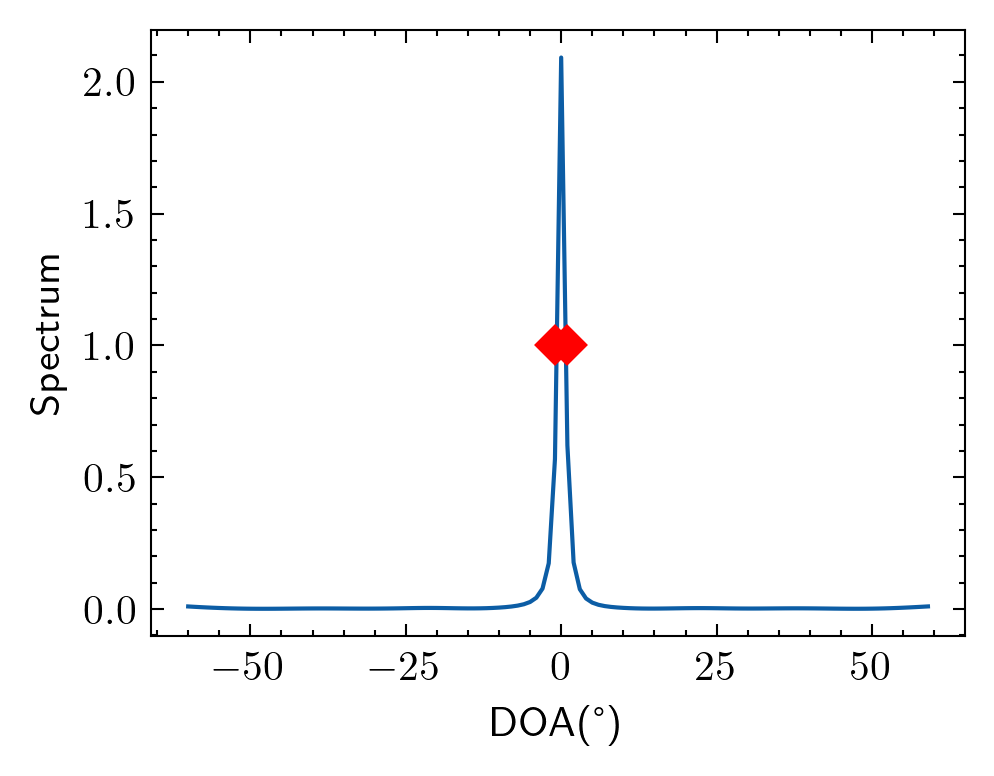

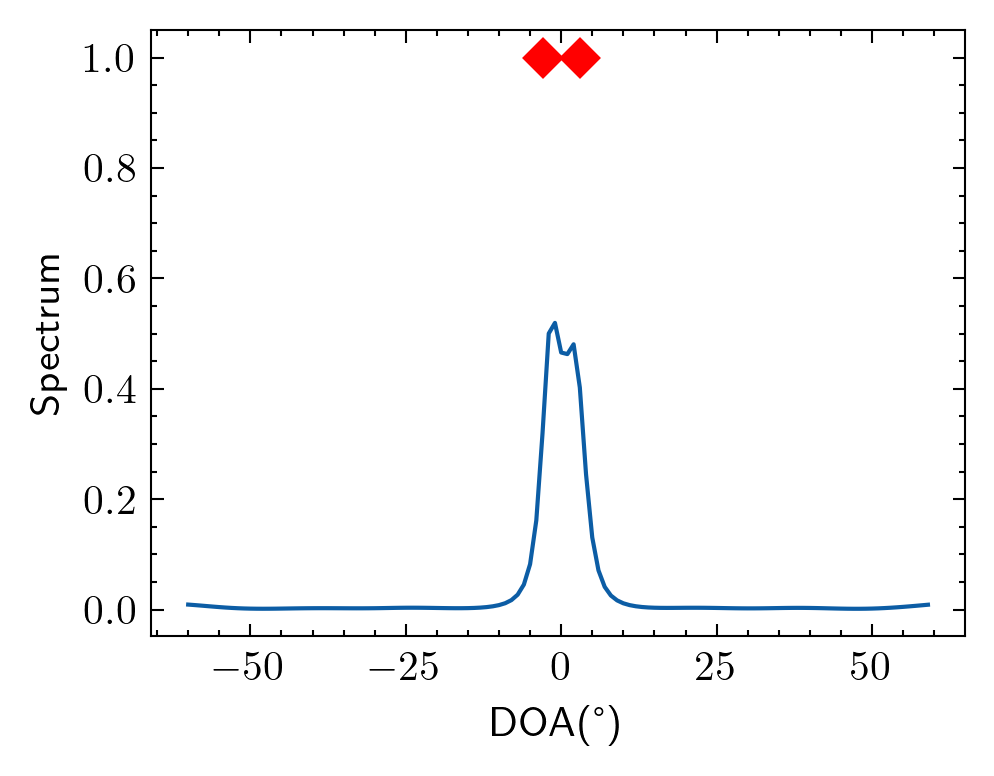

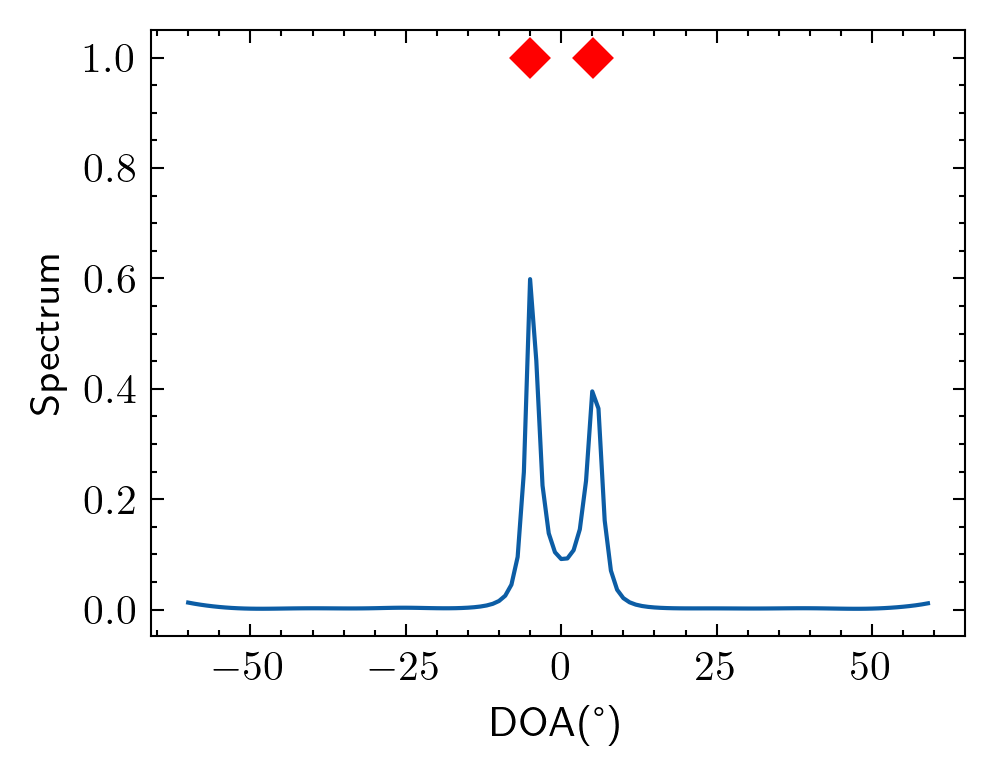

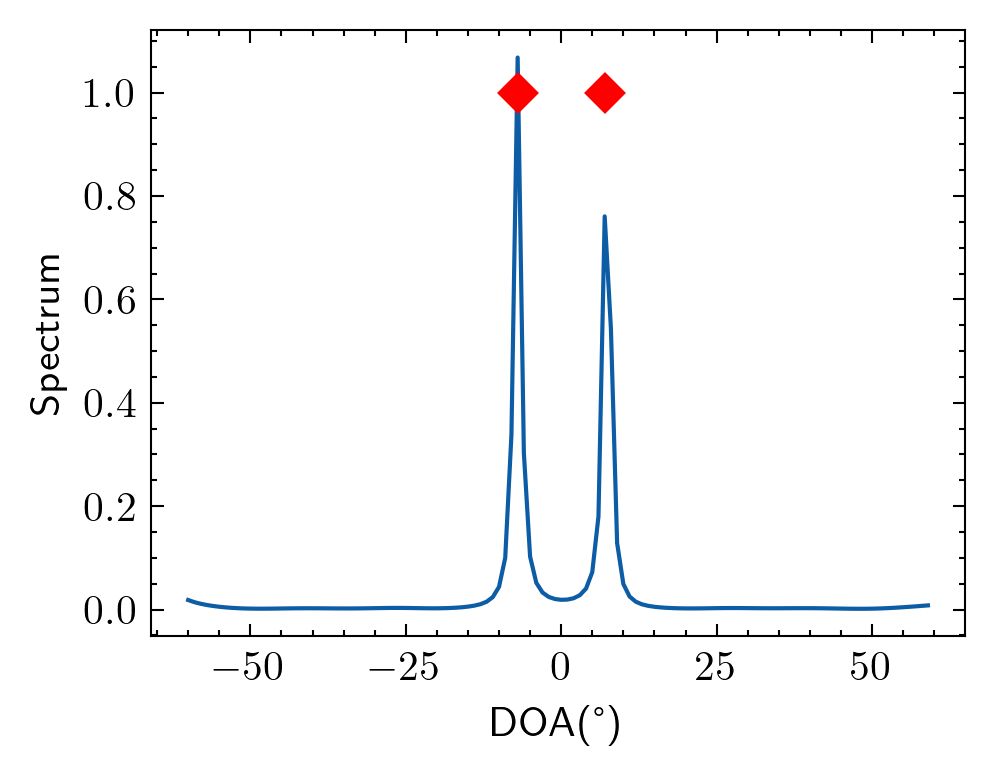

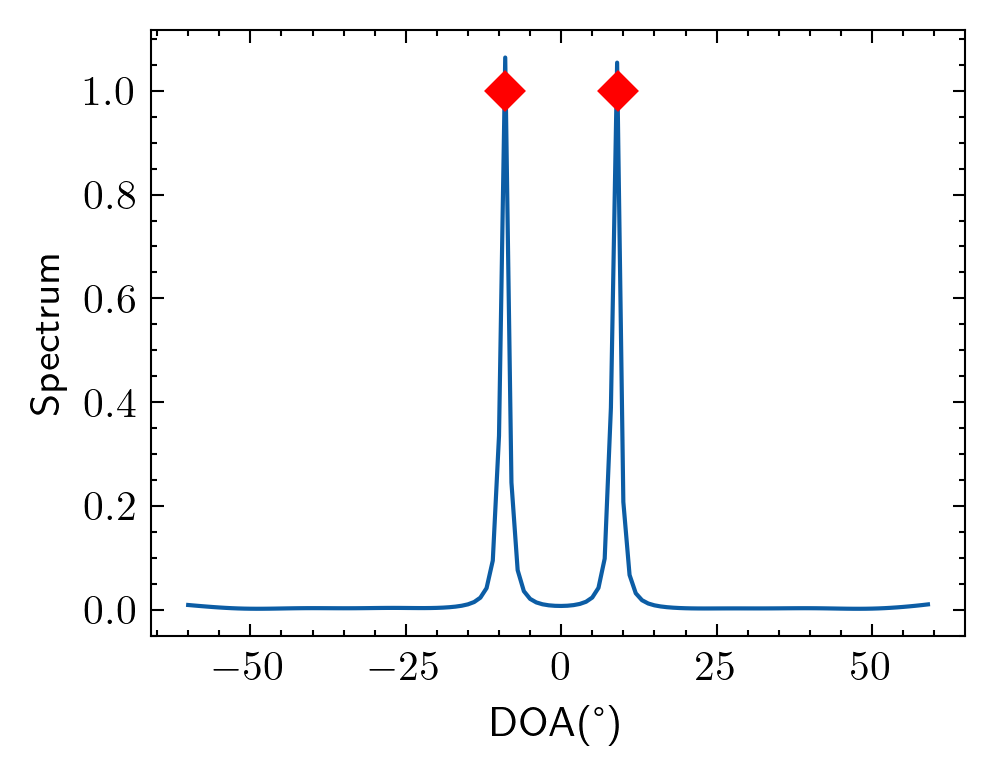

In [221]:
with plt.style.context(['science']):
    plt.rcParams['figure.dpi'] = 300
    DOA_plot = np.arange(r2)
    for i in DOA_plot:
        plt.size = (20,20)
        x = np.arange(-60,60)
        y = gamma[i,:]
        plt.figure()
        plt.xlabel('DOA(°)')
        plt.ylabel('Spectrum')
        plt.plot(x, y)
        plt.plot(DOA_train[:,i],np.ones((2,)),'rD')
        plt.savefig(figurepath + '/Spectrum/SBL/DOA'+str(i)+'.pdf')